<a href="https://colab.research.google.com/github/OkoksNeDam/geoinformation-data-forecasting/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting data from KEV station with LSTM

## Import libraries

In [ ]:
import torch
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random
import os
import copy

## Seed everything

In [ ]:
SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    tf.random.set_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(SEED)
g = torch.Generator()
g.manual_seed(SEED)

## Install data

In [ ]:
import gdown
# Main data.
data_url         = 'https://drive.google.com/drive/folders/1HH70Q8NDpA3kPflrldGSdYRUs5tWxclI?usp=sharing'

links = [data_url]

# Downloading data.
for url in links:
    gdown.download_folder(url, quiet=True)

In [ ]:
df_train, df_val, df_test = pd.read_csv('/content/data/train/train.csv'), pd.read_csv('/content/data/val/val.csv'), pd.read_csv('/content/data/test/test.csv')

In [ ]:
df_train.head()

,ds,y
0,2003-01-01 01:00:00,1824.7
1,2003-01-01 02:00:00,1823.6
2,2003-01-01 03:00:00,1814.7
3,2003-01-01 04:00:00,1816.8
4,2003-01-01 05:00:00,1816.4


## Necessary functions

Define method for fill missing values

In [ ]:
def fill_missing_values(dataframe, method):
    dataframe = dataframe.copy(deep=True)
    # fill with mean.
    if method == 'mean':
        return dataframe.fillna(dataframe.mean(numeric_only=True).round(1))
    # fill with median.
    if method == 'median':
        return dataframe.fillna(dataframe.median(numeric_only=True).round(1))
    # if there are nan left, fill with bfill.
    if method == 'ffill':
        return dataframe.fillna(method=method).fillna(method='bfill')
    # filling occurs with next values.
    # if there are nan left, fill with ffill.
    if method == 'bfill':
        return dataframe.fillna(method=method).fillna(method='ffill')
    # fill with backward interpolation.
    # if there are nan left, fill with forward.
    if method == 'interpolate_backward':
        return dataframe.apply(lambda col: col.interpolate(method ='linear', limit_direction ='backward')
                                              .interpolate(method ='linear', limit_direction ='forward') if col.name != "ds" else col)
    # fill with knn method.
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=15)
        dataframe = dataframe.apply(lambda col: imputer.fit_transform(col.to_numpy().reshape(-1, 1)).T[0] if col.name != "ds" else col)
        return dataframe

    return dataframe

Method to split data into sequences

In [ ]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

Method for calculating smape metric

In [ ]:
def calc_smape(actual, predicted) -> float:

    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)

    return np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)) / 2) ) * 100

Visualization of metrics while training

In [ ]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_metrics(train_losses, val_mape, val_smape):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train loss')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(val_mape) + 1), val_mape, label='val mape')
    axs[1].plot(range(1, len(val_smape) + 1), val_smape, label='val smape')
    axs[1].set_ylabel('mape/smape')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
def find_best_metric_by_filling_method(train, val, method):
    df_train_filled = fill_missing_values(train, method=method)
    df_val_filled = fill_missing_values(val, method=method)

    scaler = StandardScaler()
    df_train_filled.y = scaler.fit_transform(np.array(df_train_filled.y).reshape(-1, 1)).T[0]
    df_val_filled.y = scaler.transform(np.array(df_val_filled.y).reshape(-1, 1)).T[0]

    df_train_filled.index = pd.to_datetime(df_train_filled['ds'], format='%Y-%m-%d %H:%M:%S')
    df_val_filled.index = pd.to_datetime(df_val_filled['ds'], format='%Y-%m-%d %H:%M:%S')

    df_train_filled.drop(columns=['ds'], inplace=True)
    df_val_filled.drop(columns=['ds'], inplace=True)

    WINDOW_SIZE = 5

    X_train, y_train = df_to_X_y(df_train_filled, WINDOW_SIZE)
    X_val, y_val = df_to_X_y(df_val_filled, WINDOW_SIZE)

    model = Sequential()
    model.add(InputLayer((5, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=[RootMeanSquaredError()])
    model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

    return min(model_history.history['val_loss'])

## Find best method for filling missing values:

### 1. Fill NaN values with <i><b>mean</b></i> method.

In [ ]:
mean_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'mean')

Epoch 1/20
4553/4553 [==============================] - 29s 6ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 2/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 3/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 4/20
4553/4553 [==============================] - 48s 10ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 5/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 6/20
4553/4553 [==============================] - 32s 7ms/step - loss: 0.0144 - root_mean_squared_error: 0.1199 - val_

KeyboardInterrupt: 

In [ ]:
print(f'Best val_loss for mean: ', mean_best_val_loss)

### 2. Fill NaN values with <i><b>median</b></i> method.

In [ ]:
median_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'median')

Epoch 1/20
4553/4553 [==============================] - 29s 6ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 2/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 3/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 4/20
4553/4553 [==============================] - 48s 10ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 5/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 6/20
2349/4553 [==============>...............] - ETA: 13s - loss: 0.0141 - root_mean_squared_error: 0.1186

In [ ]:
print(f'Best val_loss for median: ', median_best_val_loss)

### 3. Fill NaN values with <i><b>ffill</b></i> method.

In [ ]:
ffill_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'ffill')

Epoch 1/20
4553/4553 [==============================] - 29s 6ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 2/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 3/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 4/20
4553/4553 [==============================] - 48s 10ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 5/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 6/20
2349/4553 [==============>...............] - ETA: 13s - loss: 0.0141 - root_mean_squared_error: 0.1186

In [ ]:
print(f'Best val_loss for ffill: ', ffill_best_val_loss)

### 4. Fill NaN values with <i><b>bfill</b></i> method.

In [ ]:
bfill_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'bfill')

Epoch 1/20
4553/4553 [==============================] - 29s 6ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 2/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 3/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 4/20
4553/4553 [==============================] - 48s 10ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 5/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 6/20
2349/4553 [==============>...............] - ETA: 13s - loss: 0.0141 - root_mean_squared_error: 0.1186

In [ ]:
print(f'Best val_loss for bfill: ', bfill_best_val_loss)

### 5. Fill NaN values with <i><b>interpolate_backward</b></i> method.

In [ ]:
interpolate_backward_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'interpolate_backward')

Epoch 1/20
4553/4553 [==============================] - 29s 6ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 2/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 3/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 4/20
4553/4553 [==============================] - 48s 10ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 5/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 6/20
2349/4553 [==============>...............] - ETA: 13s - loss: 0.0141 - root_mean_squared_error: 0.1186

In [ ]:
print(f'Best val_loss for interpolate_backward: ', interpolate_backward_best_val_loss)

### 6. Fill NaN values with <i><b>knn</b></i> method.

In [ ]:
knn_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'knn')

Epoch 1/20
4553/4553 [==============================] - 29s 6ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 2/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 3/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 4/20
4553/4553 [==============================] - 48s 10ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 5/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 6/20
2349/4553 [==============>...............] - ETA: 13s - loss: 0.0141 - root_mean_squared_error: 0.1186

In [ ]:
print(f'Best val_loss for knn: ', knn_best_val_loss)

## Prediction on test data

In [ ]:
cp1 = ModelCheckpoint('model1_filled_mean/', save_best_only=True, monitor='val_loss')

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('model1_filled_mean/')

TypeError: Error when deserializing class 'MeanSquaredError' using config={'reduction': 'none', 'name': 'mean_squared_error'}.

Exception encountered: MeanSquaredError.__init__() got an unexpected keyword argument 'reduction'

In [ ]:
val_predictions = loaded_model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':list(val_predictions), 'Actuals':list(y_val)})
val_results

In [ ]:
mean_squared_error(val_results['Actuals'], val_results['Val Predictions']), calc_smape(val_results['Actuals'], val_results['Val Predictions'])

In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':list(test_predictions), 'Actuals':list(y_test)})
test_results

569/569 [==============================] - 2s 3ms/step


,Test Predictions,Actuals
0,2.390884,[2.3594143078909866]
1,2.337676,[2.2798532168763446]
2,2.270550,[2.2312007511479663]
3,2.219984,[2.169383500575441]
4,2.164790,[2.1527844240328173]
...,...,...
18202,2.568502,[2.6393090813165974]
18203,2.568502,[2.6393090813165974]
18204,2.568502,[2.6393090813165974]
18205,2.568502,[2.6393090813165974]


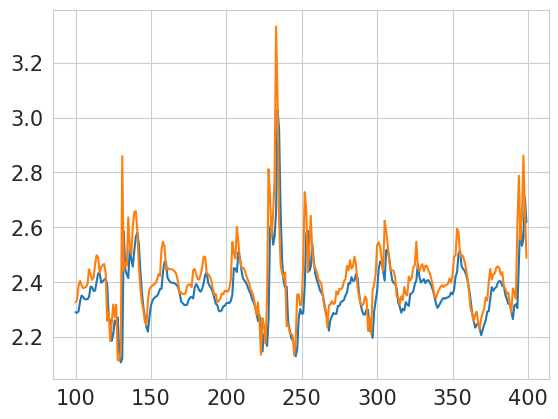

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_results['Test Predictions'][100:400])
plt.plot(test_results['Actuals'][100:400])

In [ ]:
calc_smape(test_results['Actuals'], test_results['Test Predictions'])

array([3.90666164])

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_results['Actuals'], test_results['Test Predictions'])

0.027371647150324335